# Second-Simplest  Reinforcement Learning

by Florian Marquardt, 2017

This is probably the second-simplest possible reinforcement learning example (after the random walk, where the action does not even depend on the state, and the reward only depends on the final distance traveled).

Here is the game:

A walker moves on a 1D lattice. In each time step, it can either stay or move to the right. The probabilities for these two actions are calculated by a neural network (softmax output for the two probabilities). The input to the network is the 'state' of the current lattice point. This is 0 most of the time, for 'regular' lattice points. However, there is one special lattice point, the target, where the network receives 1 as input. This target is placed randomly to the right of the origin at the beginning of time. The total trajectory is finished after a fixed number of time steps.

The reward for a given trajectory is equal to the number of time steps that the walker had been sitting on top of the target point. 

In other words, the network has to learn that it should always move as long as it is not yet on target, and then stop once it encounters the target. This is the optimal strategy.

We apply basic policy gradient, with simple stochastic gradient descent, on a simple fully connected network with one hidden layer (1 input neuron, 2 hidden, 2 output neurons with softmax).

What we found:

(1) It works!

(2) It seems that simple stochastic gradient descent is better than more complicated approaches.

(3) One can scale the reward to large values (or, equivalently, increase the learning rate), and thereby get very fast convergence, after only about *50 trajectories* (!).

(4) Choosing a larger batch size (i.e. the number of trajectories that are simulated in parallel, and over which the weight update is averaged) is NOT better. A batch size of 10 gives much faster convergence than, say, 100 or 1000. I suspect that this is because smaller batch sizes introduce *larger* fluctuations, which happen to be good in the beginning of learning, to explore strategies.

(5) Even after convergence, the average reward (averaged over a batch) can still fluctuate quite strongly from batch to batch, even for rather large batch sizes (like 1000). I suspect these fluctuations are far larger than simply due to the random placement of targets. So one should then stop learning when one is currently at a very good reward (possibly).



In [22]:
# Import keras library. Also import some of the layers, so we do not need to
# write things like "layers.Dense", but can just write "Dense" instead
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Import the numpy library for matrix manipulations etc.
from numpy import *

# Set up the graphics by importing the matplotlib plotting library
import matplotlib.pyplot as plt
%matplotlib inline

# Set up a random number generator with a fixed seed, so that
# running this whole notebook repeatedly should always give
# the same result (useful for debugging)
rng = random.RandomState(23455)

import time

In [41]:
# initialize the network

def init_net():
    global net, batchsize
    net = Sequential()
    # note: batch_input_shape is (batchsize,data_dim)
    net.add(Dense(2, input_shape=(1,), activation='sigmoid'))
    net.add(Dense(2, activation='softmax'))
    net.compile(loss='categorical_crossentropy', optimizer=tensorflow.keras.optimizers.SGD(lr=0.01), metrics=['accuracy'])

In [24]:
# VERY simple version:
# ACTION = walker step (0,1=stay,go right)
# OBSERVATION (returned to net) = are we on target?

def apply_action(actions): # apply action and return next observation
    global target_positions # array of batchsize, where to find the targets
    global walker_positions # array (batchsize), walker positions
    global batchsize # batchsize (number of trajectories processed in parallel)
        
    walker_positions+=actions
    return(1-sign(abs(target_positions-walker_positions)))

In [42]:
target_max=10 # how far out to place the target (at maximum)

# initialize all the target and walker positions
def init_batch():
    global target_positions, walker_positions, batchsize
    global target_max
    
    target_positions=random.randint(target_max, size=batchsize)
    walker_positions=zeros(batchsize)

Just check whether the action method works, for a random walker

In [43]:
def draw_random_actions(dist): 
    # given a batchsize x num_actions probability distribution
    # return a batchsize array of actions (0 or 1)
    # thanks to Thomas for sped-up version
    global batchsize

    p=random.random(batchsize)
    output=(p>dist[:,0]).astype(dtype='int')
    return(output)

In [44]:
# perform one 'epoch':
# 1. run 'batchsize' trajectories
#    in parallel, for 'nsteps' timesteps
# 2. Calculate reward for each trajectory
# 3. Use that for training update on the network (reinforcement learning)
#    This implements 'policy gradient', where (roughly)
#       dWeight = dlog(p)/dWeight * Reward
#    Here, we do this automatically by having the categorical
#    crossentropy as cost function (see definition of rnn above!)
#    That contains the required logarithm. Training update is always
#    only done on the actions that actually had been performed!
def do_epoch(epoch):
    global batchsize, actions, timerA, timerB, timerC
    global observations, observations_history, actions, probs, creative_epsilon
    global action_taken, observations_history
    global target_history, walker_history
    global target_positions, walker_positions
    global FinalReward, RewardWeights, RewardScaling
    global avg_reward, last_avg_reward
    global net
    
    # go through a batch of trajectories a first time:
    actions=random.randint(2,size=batchsize)
    init_batch() # initialize walker positions etc. ('environment')
    
    timerStart=time.clock()
    for j in range(nsteps): # loop through all time steps
        # ********* APPLY ACTIONS AND GET BACK OBSERVATIONS ********
        observations=apply_action(actions) # apply the action that was selected
        
        InputArray[:,0]=observations # the observations (in proper shape)
        
        # ********* FEED OBSERVATIONS INTO NET AND GET PROBABILITY DISTRIBUTION FOR ACTIONS ********
        probs = net.predict_on_batch(InputArray)[:,:] # (batchsize x num_actions) will represent the prob. distribution for next action recommended    

        # ********* DRAW ACTION RANDOMLY ACCORDING TO PROB. DIST. (or do some random 'creative' step) ********        
        if random.rand()<creative_epsilon:
            actions=random.randint(2,size=batchsize) # select action completely randomly
        else:
            actions=draw_random_actions(probs) # select action randomly, according to probs
        # that's it! in the next step of the loop, we will perform this action
        # store a few things for later:
        action_taken[:,j]=actions.astype(dtype='int') # store actions (will be carried out in next step)
        observations_history[:,j]=observations
        target_history[epoch,:,j]=target_positions
        walker_history[epoch,:,j]=walker_positions
    timerA+=time.clock()-timerStart
    
    # ********* CALCULATE REWARD FOR EACH TRAJECTORY ********
    # simply: the number of timesteps during which walker==target
    FinalReward[:]=(1-sign(abs(target_history[epoch,:,:]-walker_history[epoch,:,:]))).sum(1)
    RewardWeights=FinalReward
        
    timerStart=time.clock()
    BigInputArray=zeros([batchsize,nsteps,1])
    BigInputArray[:,:,0]=observations_history[:,:]    
    action_one_hots=zeros([batchsize,nsteps,2])

    for j in range(nsteps):
        action_one_hots[range(batchsize),j,action_taken[:,j]]=RewardScaling*RewardWeights

    timerB+=time.clock()-timerStart
    
    timerStart=time.clock()  
    # ********* TRAINING (now: on full time span, not individual steps) ********    
    net.train_on_batch(reshape(BigInputArray,[batchsize*nsteps,1]),reshape(action_one_hots,[batchsize*nsteps,2]))
    timerC+=time.clock()-timerStart
    
    # store rewards, and get running average of 'last' reward
    # the last reward will be subtracted in the rewards calculation
    # this should make for better learning
    avg_reward[epoch]=sum(FinalReward)/batchsize
    last_avg_reward=last_avg_reward*0.9+0.1*avg_reward[epoch]


In [45]:
batchsize=10
init_net() # completely fresh start

In [47]:
# Run a number of epochs for training!
num_epochs=100
nsteps=20 # number of time steps
creative_epsilon=0.01 # probability to take a random action (exploration)

# set up a few global variables, to hold auxiliary data
avg_reward=zeros(num_epochs)
InputArray=zeros([batchsize,1]) # auxiliary, to feed input into net
action_taken=zeros([batchsize,nsteps],dtype='int') # to store the actions
FinalReward=zeros(batchsize) # the reward for each trajectory
walker_history=zeros([num_epochs,batchsize,nsteps]) # the trajectory
test_walker_history=zeros([num_epochs,batchsize,nsteps]) # the trajectories for the 'test' case (i.e. always based on observations of epoch 0)
target_history=zeros([num_epochs,batchsize,nsteps]) # the targets moving around
observations_history=zeros([batchsize,nsteps]) # the observations
last_avg_reward=0

RewardScaling=60 # will determine size of reward and thus speed of learning

timerA=0
timerB=0
timerC=0

for epoch in range(num_epochs):
    do_epoch(epoch)
    print("\r Epoch ", epoch, " --- average reward ", avg_reward[epoch],end="                        ")


print("\nTotal time for first runs:", timerA)
print("Total time for setting up training:", timerB)
print("Total time for training:", timerC)


 Epoch  99  --- average reward  12.2                        39  --- average reward  12.9                        
Total time for first runs: 1.2423049999999982
Total time for setting up training: 0.02273199999996578
Total time for training: 0.2624490000000179


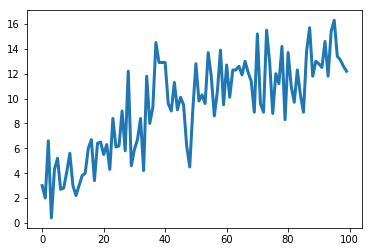

In [48]:
plt.plot(avg_reward,linewidth=3)

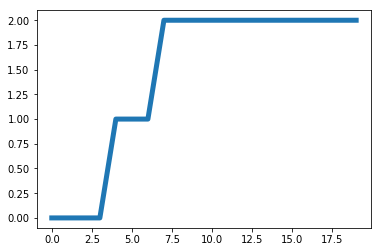

In [53]:
plt.plot(walker_history[0,3,:],linewidth=5)

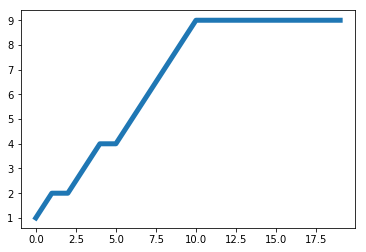

In [54]:
plt.plot(walker_history[-1,0,:],linewidth=5)
plt.show()

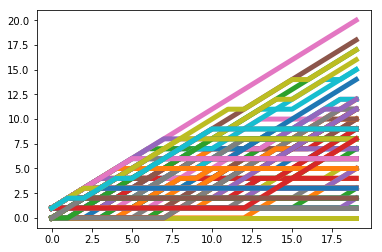

In [55]:
for j in range(num_epochs):
    plt.plot(walker_history[j,0,:],linewidth=5)